In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import math



# Data processing

In [3]:
users=pd.read_csv(r'/content/drive/MyDrive/Colab/ML/users.dat',sep="::",names=['UserID','Gender','Age','Occupation','Zip-code'])
movies=pd.read_csv(r'/content/drive/MyDrive/Colab/ML/movies.dat',sep="::",names=['MovieID','Title','Genres'])
ratings=pd.read_csv(r'/content/drive/MyDrive/Colab/ML/ratings.dat',sep="::",names=['UserID','MovieID','Rating','Timestamp'])

<ipython-input-3-4c609c110fe4>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users=pd.read_csv(r'/content/drive/MyDrive/Colab/ML/users.dat',sep="::",names=['UserID','Gender','Age','Occupation','Zip-code'])
<ipython-input-3-4c609c110fe4>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies=pd.read_csv(r'/content/drive/MyDrive/Colab/ML/movies.dat',sep="::",names=['MovieID','Title','Genres'])
<ipython-input-3-4c609c110fe4>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as rege

Split train - test set

In [4]:
u=len(users)
m=max(movies["MovieID"])
r_train,r_test=train_test_split(ratings,test_size=0.1,stratify=ratings['UserID'])

r_train.head()

Utility matrix

In [5]:
user_item=np.full((m,u),np.nan)
for r in r_train.itertuples():
    user_item[r[2]-1][r[1]-1]=r[3]

user_item_test=np.full((m,u),np.nan)
for r in r_test.itertuples():
    user_item_test[r[2]-1][r[1]-1]=r[3]
user_item

Similarity matrix

In [6]:
mean=np.nanmean(user_item,axis=1)
for i in range(m):
    user_item[i]=user_item[i]-mean[i]
    user_item_test[i] = user_item_test[i] - mean[i]

nan_cell=np.argwhere(np.isnan(user_item))

user_item=np.nan_to_num(user_item)

<ipython-input-6-be96d6d2cc6a>:1: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(user_item,axis=1)


In [7]:
nan_list=[[] for i in range(u)]
for cell in nan_cell:
    nan_list[cell[1]].append(cell[0])
# nan_cell

In [8]:
def similarity(x,y):
    if np.dot(x,y)==0:
        return 0
    return np.dot(x,y)/math.sqrt(np.sum(x**2)*np.sum(y**2))

In [9]:
similarity_matrix=np.full((m,m),np.nan)
for movie_1 in range(m):
    for movie_2 in range(movie_1+1):
        res=similarity(user_item[movie_1],user_item[movie_2])
        similarity_matrix[movie_1][movie_2]=res
        similarity_matrix[movie_2][movie_1]=res

similarity_matrix

array([[ 1.        ,  0.08175742,  0.02657457, ...,  0.01021887,
         0.0143009 ,  0.01924492],
       [ 0.08175742,  1.        ,  0.02032628, ..., -0.00640565,
        -0.00831137,  0.00252573],
       [ 0.02657457,  0.02032628,  1.        , ...,  0.0361254 ,
         0.01877303,  0.01731341],
       ...,
       [ 0.01021887, -0.00640565,  0.0361254 , ...,  1.        ,
         0.05133325,  0.06204155],
       [ 0.0143009 , -0.00831137,  0.01877303, ...,  0.05133325,
         1.        ,  0.14212449],
       [ 0.01924492,  0.00252573,  0.01731341, ...,  0.06204155,
         0.14212449,  1.        ]])

Prediction

In [12]:
def predict(user,movie,k):
    copy=np.array(similarity_matrix[movie])

    np.delete(copy,nan_list[user])
    neighbor=(-copy).argsort()[1:k+1]
    similar=copy[neighbor]
    rate=user_item.T[user][neighbor]
    if np.sum(similar)!=0:
        return (rate@similar)/np.sum(np.abs(similar))
    return 0

In [13]:
rmse = []
mae = []
precision = []
recall = []
NDCG = []
iteration_list = [1,5,10,15,30,50,100]
for k in iteration_list:
    similarity_matrix=np.nan_to_num(similarity_matrix)
    mean=np.nan_to_num(mean)
    para = 0
    se=0
    e=0
    tp=0
    tp_fp=0
    tp_tn=0
    DCG = []
    IDCG = sorted(r_test['Rating'])[::-1]
    for r in r_test.itertuples():
        pred=predict(r[1]-1,r[2]-1,k)
        user_item[r[2]-1][r[1]-1]=pred+mean[r[2]-1]
        DCG.append(pred+mean[r[2]-1])
        if pred>para:
            tp_fp+=1
        if r[3]>mean[r[2]-1]+para:
            tp_tn += 1
            if pred>para:
                tp+=1
        se+=(user_item[r[2]-1][r[1]-1]-r[3])**2
        e+=math.fabs(user_item[r[2]-1][r[1]-1]-r[3])
    DCG = sorted(DCG)[::-1]
    NDCG.append(ndcg_score([IDCG], [DCG]))
    rmse.append(math.sqrt(se/len(r_test)))
    mae.append(e/len(r_test))
    precision.append(tp/tp_fp)
    recall.append(tp/tp_tn)

In [18]:
NDCG = []
iteration_list = [1,5,10,15,30,50,100]
for k in iteration_list:
    similarity_matrix=np.nan_to_num(similarity_matrix)
    mean=np.nan_to_num(mean)
    DCG = []
    IDCG = sorted(r_test['Rating'])[::-1]
    for r in r_test.itertuples():
        pred=predict(r[1]-1,r[2]-1,k)
        DCG.append(pred+mean[r[2]-1])
    DCG = sorted(DCG)[::-1]
    NDCG.append(ndcg_score([IDCG[:10]], [DCG[:10]]))
NDCG

[0.9999999999999997,
 0.9999999999999997,
 0.9999999999999997,
 0.9999999999999997,
 0.9999999999999997,
 0.9999999999999997,
 0.9999999999999997]

RMSE:  [1.125942967499388, 1.019262345327438, 0.9590994622172946, 0.9423295043988122, 0.9334034523222807, 0.9323004529855101, 0.9350691355645259]


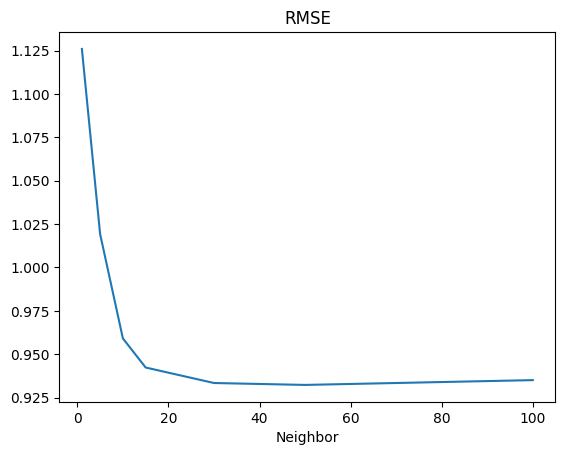

In [14]:
import matplotlib.pyplot as plt
from importlib import reload
print("RMSE: ",rmse)
plt=reload(plt)
plt.plot(iteration_list, rmse)
plt.xlabel('Neighbor')
plt.title('RMSE')
plt.show()

In [ ]:
print("MAE: ",mae)
plt=reload(plt)
plt.plot(iteration_list, mae)
plt.xlabel('Neighbor')
plt.title('MAE')
plt.show()

Precision:  [0.6883598841419262, 0.6458324340656969, 0.6360465952398073, 0.6318649362734509, 0.6235991010433255, 0.6186662926863474, 0.6136999683176682]


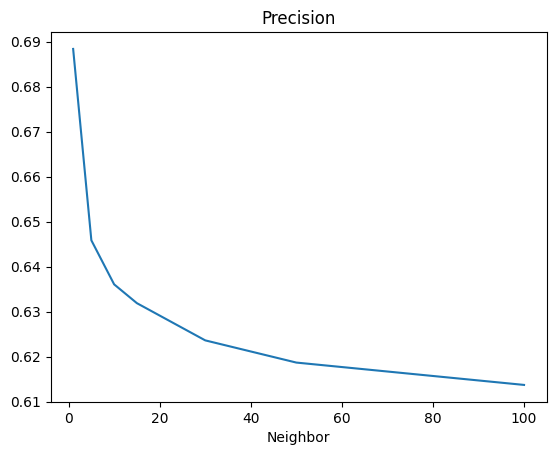

In [15]:
print("Precision: ",precision)
plt=reload(plt)
plt.plot(iteration_list, precision)
plt.xlabel('Neighbor')
plt.title('Precision')
plt.show()

Recall:  [0.2833299182236462, 0.5574204124210644, 0.6590913324516141, 0.7083247955591155, 0.7804891678930015, 0.8217499022036772, 0.8659910958776521]


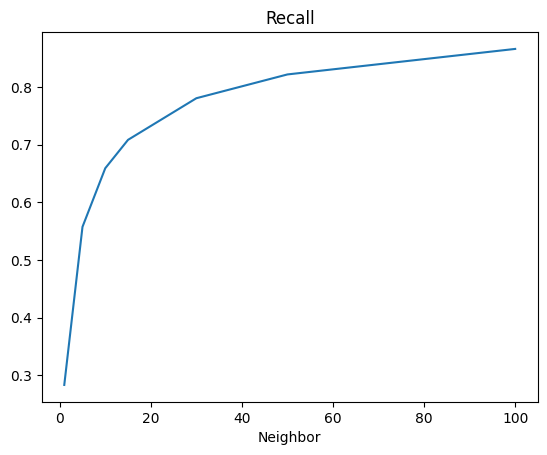

In [16]:
print("Recall: ",recall)
plt=reload(plt)
plt.plot(iteration_list, recall)
plt.xlabel('Neighbor')
plt.title('Recall')
plt.show()

NDCG:  [0.9999999620132751, 0.999999999997362, 0.9999999993790541, 0.999999999999999, 0.999999999999999, 0.9999999999999991, 0.9999999999999991]


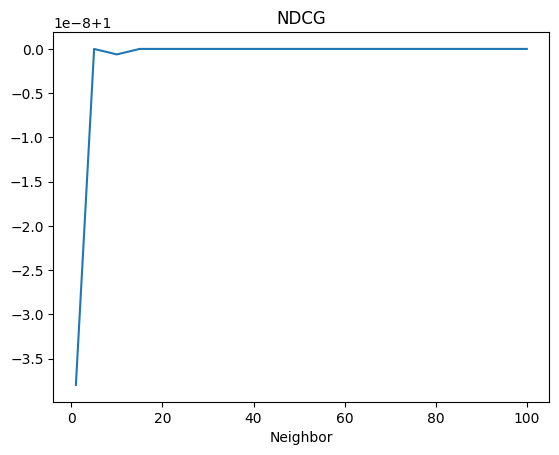

In [17]:
print("NDCG: ",NDCG)
plt=reload(plt)
plt.plot(iteration_list, NDCG)
plt.xlabel('Neighbor')
plt.title('NDCG')
plt.show()